In [1]:
import tensorflow as tf

print(tf.__version__)

2.0.0


In [2]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
inputs = keras.Input(shape=(128, 128, 3), name='img')

x = layers.Conv2D(
    filters=64,             # 卷积层神经元（卷积核）数目
    kernel_size=9,          # 感受野大小
    padding='same',         # padding策略（vaild 或 same）
    activation=tf.nn.relu   # 激活函数
)(inputs)

x = layers.Conv2D(
    filters=32,      
    kernel_size=1,
    padding='same',  
    activation=tf.nn.relu
)(x)

outputs = layers.Conv2D(
    filters=3,
    kernel_size=5,          
    padding='same'          # 不设置激活函数
)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='SRCNN_model')# 通过在图层图中指定其输入和输出来创建一个model
  
model.summary() # 查看模型摘要，需要模型built（实例化）后调用

Model: "SRCNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      15616     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      2080      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 3)       2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [6]:
import cv2 as cv
import numpy as np

'''
CIFAR10 had't 128*128*3 images use bicubic alternatived,and bicubic use nearest alternatived.
X_: image applied bicubic interpolation (low-resolution),(50000, 128, 128, 3)
y_: image with original resolution (high-resolution),(10000, 128, 128, 3)
'''

ishape = 128

# load data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# 缩小数据集,控制内存占用(以下win10，8G内存可用)
train_image = train_images[0:10000]
test_image  = test_images[0:1000]

X_train = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in train_image]) / 255.
X_test  = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in test_image]) / 255.

y_train = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_CUBIC) for i in train_image]) / 255.
y_test  = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_CUBIC) for i in test_image]) / 255.

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',       
              metrics=['mae'])    # 编译

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=3,
                    validation_split=0.2)# 训练

test_scores = model.evaluate(X_test, y_test, verbose=2) # 评估

print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])

# Save entire model to a HDF5 file
model.save('SRCNN.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/3
8000/8000 [==============================] - 480s 60ms/sample - loss: 0.2165 - mae: 0.1765 - val_loss: 0.0113 - val_mae: 0.0715
Epoch 2/3
8000/8000 [==============================] - 490s 61ms/sample - loss: 0.0088 - mae: 0.0615 - val_loss: 0.0055 - val_mae: 0.0467
Epoch 3/3
8000/8000 [==============================] - 480s 60ms/sample - loss: 0.0036 - mae: 0.0351 - val_loss: 0.0028 - val_mae: 0.0306
1000/1 - 11s - loss: 0.0028 - mae: 0.0309
Test loss: 0.0028563126549124716
Test mae: 0.03087139


# 使用

## 跳过训练，加载模型即可直接使用

In [ ]:
import tensorflow as tf

# Recreate the exact same model, including weights and optimizer.
model = tf.keras.models.load_model('SRCNN.h5')

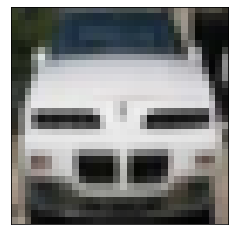

In [8]:
import cv2 as cv
from matplotlib import pyplot as plt

ishape = 128

#加载放大图像并显示
img = cv.imread('automobile.png')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)# (36,36,3)->(128,128,3)

plt.imshow(img)

plt.xticks([]), plt.yticks([])

plt.show()

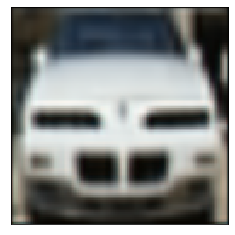

In [9]:
import numpy as np

img = np.reshape(img,(1,ishape,ishape,3)) / 255.

# 处理图像超分辨率
img_SR = model.predict(img)

plt.imshow(img_SR[0])

plt.xticks([]), plt.yticks([])

plt.show()